In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
date_columns = ['date', 'inference_time']
categoric_columns = ['month', 'week', 'day_of_week', 'day', 'year']
dtype_categoric = dict([(c,'category') for c in categoric_columns])

data = pd.read_csv('../../data/avocados_demand_forecasting_dataset.csv', dtype=dtype_categoric, parse_dates=date_columns)

In [6]:
train_start_date = data['inference_time'].min()
train_end_date = data['inference_time'].min() + pd.DateOffset(years=1)
test_end_date = train_end_date + pd.DateOffset(months=3)
prod_end_date = data['inference_time'].max()

# Create data partition
data['partition'] = pd.cut(
    data['inference_time'],
    bins= [train_start_date,
           train_end_date,
           test_end_date,
           prod_end_date],
    right=False,
    labels= ['train', 'test', 'prod']
)

# Set target and features
target = 'demand'
features = [col for col in data.columns if col not in [target, 'partition'] + date_columns]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

## Exploring the training data

In [7]:
df = data.loc[data['partition'] == 'train', ['date', 'demand']]
df['month'] = df['date'].dt.to_period('M')
df['week'] = df['date'].dt.to_period('W')

df1 = df.copy()
df1['demand'] = df1['demand'] / 100000000
df1 = df1.reset_index()
df2 = df.groupby('month')['demand'].sum() / 100000000
df2 = df2.reset_index()

<Axes: title={'center': 'Demand in hundreds of millions avocados per week'}, xlabel='date', ylabel='demand'>

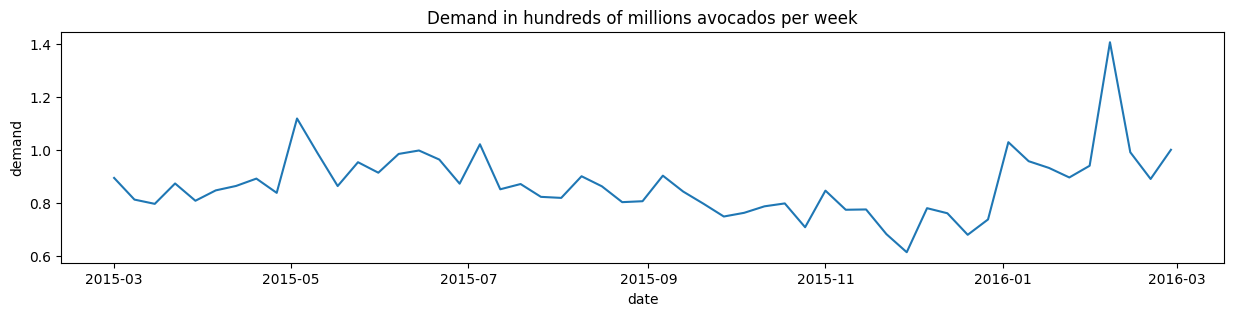

In [8]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Demand in hundreds of millions avocados per week')
sns.lineplot(data=df1, x='date', y='demand')

<Axes: title={'center': 'Demand in hundreds of millions avocados per month'}>

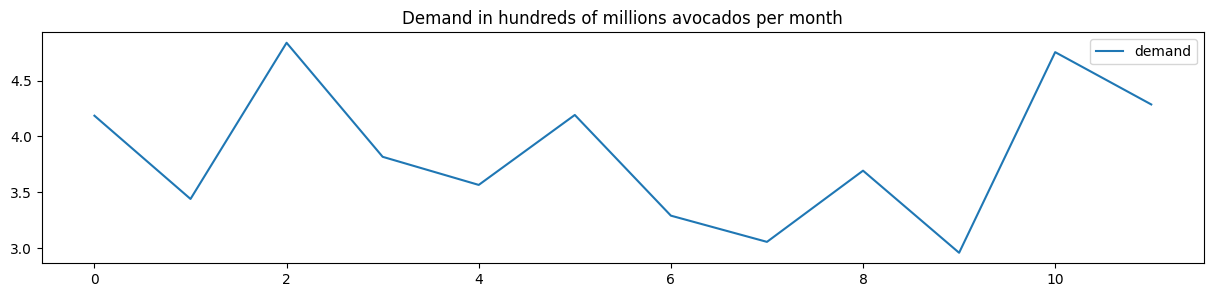

In [9]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Demand in hundreds of millions avocados per month')
df2.plot(ax=ax)

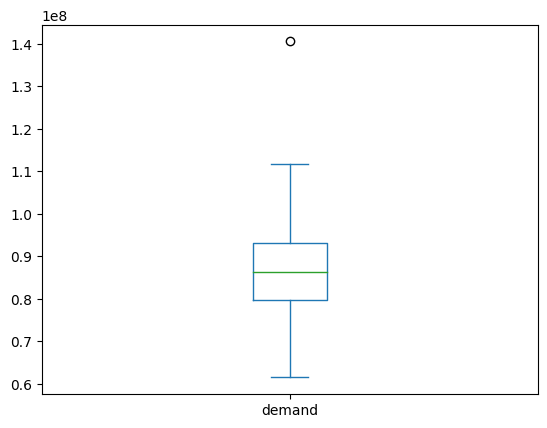

In [10]:
y_train.plot(kind='box')
plt.show()

Text(0.5, 0, 'Demand')

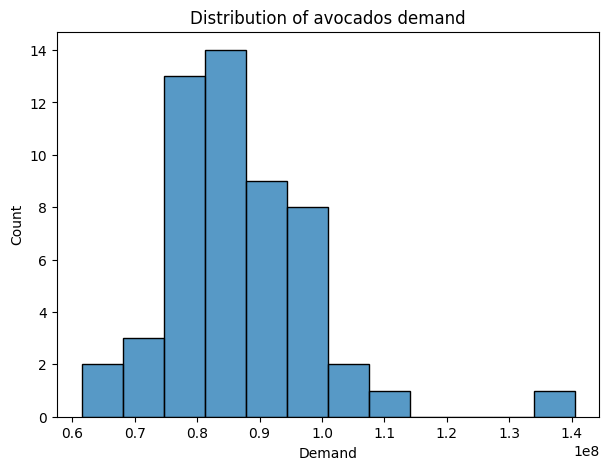

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(data=df, x='demand', ax=ax)
ax.set_title('Distribution of avocados demand')
ax.set_xlabel('Demand')

## Train a model

In [12]:
from lightgbm import LGBMRegressor, plot_importance
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

LGBMRegressor(random_state=111)

In [13]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate the model

In [14]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mape_train = mean_absolute_percentage_error(y_train, y_pred_train).round(4)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test).round(4)

mape_train_baseline = mean_absolute_percentage_error(y_train, y_pred_train_baseline).round(4)
mape_test_baseline = mean_absolute_percentage_error(y_test, y_pred_test_baseline).round(4)

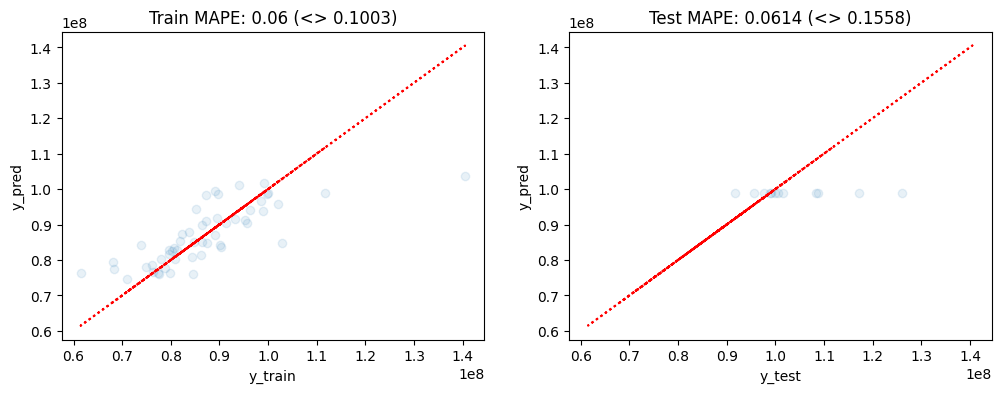

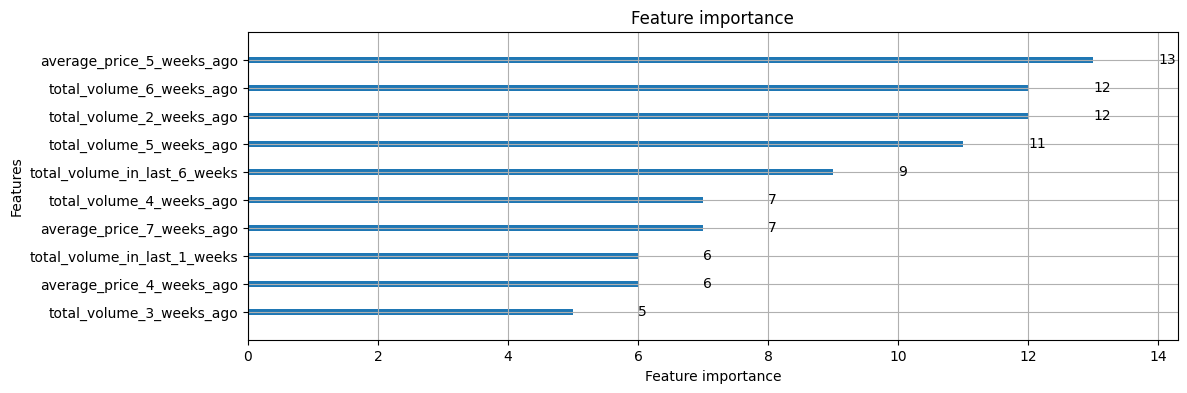

In [17]:
# Create performance report 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

upper_lim = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

title1 = 'Train MAPE: {} (<> {})'.format(mape_train, mape_train_baseline) 
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)
# ax1.set_xlim(0, upper_lim)
# ax1.set_ylim(0, upper_lim)

title2 = 'Test MAPE: {} (<> {})'.format(mape_test, mape_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_train, y_train, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)
# ax2.set_xlim(0, upper_lim)
# ax2.set_ylim(0, upper_lim)

# plt.savefig('fig_1.png', dpi=300)
plt.show()

# importances = model.feature_importances_
# feature_names = X_train.columns
# indices = np.argsort(importances)[::-1][:20]
# sorted_importances = importances[indices]
# sorted_feature_names = feature_names[indices]

# fig, ax = plt.subplots(figsize=(12,4))
# ax.set(title='Feature Importance',xlabel='Importance', ylabel='Feature', )
# ax.barh(range(len(sorted_importances)), sorted_importances, align='center')
# ax.set_yticks(range(len(sorted_importances)), sorted_feature_names)

fig, ax = plt.subplots(figsize=(12,4))
plot_importance(model, ax=ax, max_num_features=10)
# plt.savefig('fig_2.png', dpi=300)
plt.show()

## Making predictions

In [18]:
data['predicted_demand'] = model.predict(data[features])

In [19]:
data

,date,demand,inference_time,month,week,day_of_week,day,year,days_since_last_holiday,days_until_next_holiday,...,total_volume_in_last_4_weeks,total_volume_4_weeks_ago,total_volume_in_last_5_weeks,total_volume_5_weeks_ago,total_volume_in_last_6_weeks,total_volume_6_weeks_ago,total_volume_in_last_7_weeks,total_volume_7_weeks_ago,partition,predicted_demand
0,2015-03-01,8.943484e+07,2015-02-22,2,8,6,22,2015,52.0,1191.0,...,8.782078e+07,7.646628e+07,8.624878e+07,7.838878e+07,8.514978e+07,7.855581e+07,8.509035e+07,8.467434e+07,train,9.185506e+07
1,2015-03-08,8.128167e+07,2015-03-01,3,9,6,1,2015,59.0,1184.0,...,9.041449e+07,1.194532e+08,8.808979e+07,7.646628e+07,8.670393e+07,7.838878e+07,8.568541e+07,7.855581e+07,train,8.287408e+07
2,2015-03-15,7.967682e+07,2015-03-08,3,10,6,8,2015,66.0,1177.0,...,8.278018e+07,8.667111e+07,8.889235e+07,1.194532e+08,8.711720e+07,7.646628e+07,8.602615e+07,7.838878e+07,train,8.167497e+07
3,2015-03-22,8.734632e+07,2015-03-15,3,11,6,15,2015,73.0,1170.0,...,8.138132e+07,7.563716e+07,8.226295e+07,8.667111e+07,8.757585e+07,1.194532e+08,8.618715e+07,7.646628e+07,train,8.475371e+07
4,2015-03-29,8.084341e+07,2015-03-22,3,12,6,22,2015,80.0,1163.0,...,8.372315e+07,8.087609e+07,8.237549e+07,7.563716e+07,8.298915e+07,8.667111e+07,8.754716e+07,1.194532e+08,train,8.032742e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2018-02-25,1.092314e+08,2018-02-18,2,7,6,18,2018,1144.0,99.0,...,1.230858e+08,1.170872e+08,1.195761e+08,1.020277e+08,1.168934e+08,1.007971e+08,1.153008e+08,1.041529e+08,prod,9.473251e+07
157,2018-03-04,1.118449e+08,2018-02-25,2,8,6,25,2018,1151.0,92.0,...,1.215147e+08,1.097951e+08,1.207767e+08,1.170872e+08,1.180983e+08,1.020277e+08,1.159357e+08,1.007971e+08,prod,9.571289e+07
158,2018-03-11,1.114652e+08,2018-03-04,3,9,6,4,2018,1158.0,85.0,...,1.219246e+08,1.691778e+08,1.199030e+08,1.097951e+08,1.195008e+08,1.170872e+08,1.173166e+08,1.020277e+08,prod,9.048207e+07
159,2018-03-18,1.136740e+08,2018-03-11,3,10,6,11,2018,1165.0,78.0,...,1.103821e+08,1.175776e+08,1.201814e+08,1.691778e+08,1.186976e+08,1.097951e+08,1.184963e+08,1.170872e+08,prod,9.458520e+07


## Post-deployment model analysis

In [20]:
def vspan(ax, ax2=None):
    handles, labels = ax.get_legend_handles_labels()
    
    if len(handles) > 3:
        handles = handles[:2]
        labels = labels[:2]
    else:
        handles = handles[:1]
        labels = labels[:1]
    
    if ax2:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles2 = handles2[1]
        labels2 = labels2[1]
        
        handles = handles + [handles2]
        labels = labels + ['mean_absolute_error']

    ax.axvspan(train_start_date, train_end_date, color='#44AF69', alpha=0.25, zorder=-10)
    legend_patch = mpatches.Patch(color='#44AF69', alpha=0.25, label='Train')
    handles.append(legend_patch)
    labels.append('Train')

    ax.axvspan(train_end_date, test_end_date, color='#F2DC5D', alpha=0.125, zorder=-10)
    legend_patch = mpatches.Patch(color='#F2DC5D', alpha=0.125, label='Test')
    handles.append(legend_patch)
    labels.append('Test')

    ax.legend(handles=handles, labels=labels)

In [21]:
df = data[['date', 'demand', 'predicted_demand']].copy()
df['month'] = df['date'].dt.to_period('M')
df['week'] = df['date'].dt.to_period('W')

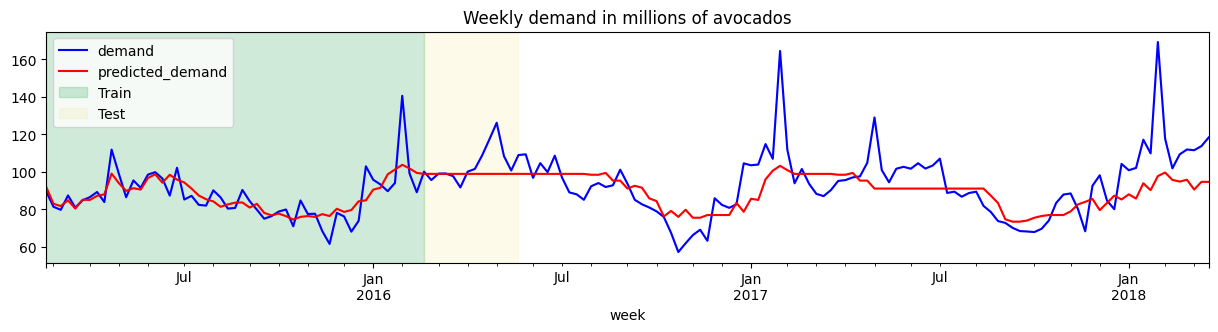

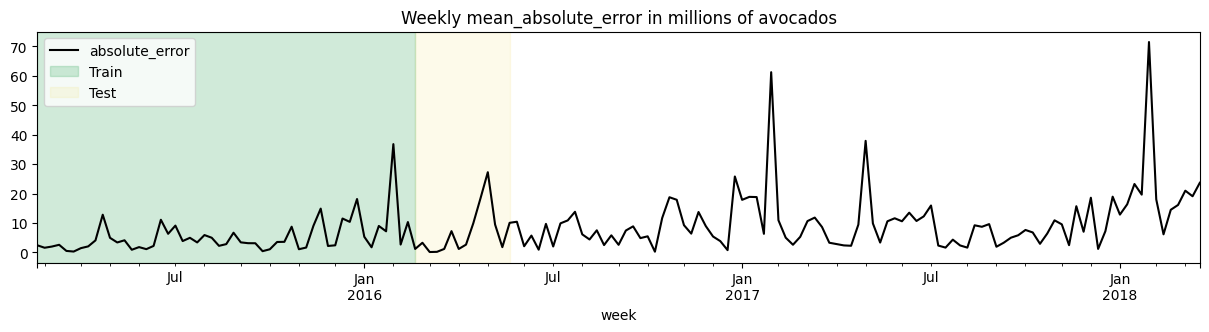

In [22]:
daily_demand = df.groupby('week')[['demand', 'predicted_demand']].sum() / 1000000
daily_demand['absolute_error'] = (daily_demand['demand'] - daily_demand['predicted_demand']).abs()
daily_demand.index = daily_demand.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Weekly demand in millions of avocados')
daily_demand[['demand', 'predicted_demand']].rolling(window=1).mean().plot(ax=ax, color=['blue', 'red'])
daily_demand[['demand', 'predicted_demand']].plot(ax=ax, alpha=0.125, legend=False, color=['blue', 'red'])
vspan(ax)

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Weekly mean_absolute_error in millions of avocados')
daily_demand[['absolute_error']].plot(ax=ax, legend=False, color=['black'])

vspan(ax)
plt.show()